In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = "../data"

In [3]:
df = pd.read_csv(os.path.join(data_dir, "OD_201912_weekday.csv"), index_col=0)

In [4]:
df2 = pd.read_csv(os.path.join(data_dir, "OD_201912_weekend.csv"), index_col=0)

In [5]:
df.head()

,origin,destination,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,hour_12,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
ind,,,,,,,,,,,,,,,,,,,,,
0,ANAK BUKIT,NORTH COAST,475.0,1159.0,2451.0,2489.0,2280.0,2280.0,2242.0,1501.0,...,874.0,2793.0,3496.0,4199.0,3230.0,3743.0,5396.0,6023.0,4370.0,2584.0
1,CLEMENTI CENTRAL,MARITIME SQUARE,4959.0,10450.0,15162.0,13167.0,10488.0,11590.0,10450.0,10678.0,...,8892.0,8018.0,8949.0,10678.0,12122.0,6821.0,4959.0,2280.0,1653.0,817.0
2,PAYA LEBAR NORTH,PASIR RIS WEST,228.0,1197.0,1558.0,1843.0,3287.0,2565.0,5225.0,6137.0,...,3762.0,4180.0,5282.0,8455.0,11324.0,9348.0,7771.0,9044.0,5985.0,2622.0
3,TRAFALGAR,TOA PAYOH WEST,1900.0,2299.0,1881.0,931.0,874.0,532.0,646.0,646.0,...,418.0,437.0,570.0,361.0,304.0,532.0,418.0,304.0,190.0,19.0
4,BALESTIER,BALESTIER,17119.0,76646.0,126616.0,205219.0,167770.0,160056.0,171380.0,188746.0,...,141208.0,139840.0,149264.0,187492.0,224162.0,194617.0,134064.0,126901.0,102999.0,63460.0


In [6]:
df2.head()

,origin,destination,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,hour_12,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
ind,,,,,,,,,,,,,,,,,,,,,
0,CLEMENTI CENTRAL,MARITIME SQUARE,969.0,3382.0,4009.0,5263.0,6042.0,7543.0,9519.0,8550.0,...,7562.0,7961.0,7486.0,6992.0,6859.0,4237.0,2470.0,874.0,817.0,570.0
1,BALESTIER,BALESTIER,5890.0,32908.0,44973.0,66557.0,88179.0,86906.0,85614.0,81453.0,...,69730.0,64866.0,72067.0,76798.0,73302.0,66215.0,57171.0,56240.0,43871.0,30761.0
2,BUKIT MERAH,MALCOLM,19.0,38.0,19.0,19.0,19.0,0.0,19.0,38.0,...,38.0,0.0,19.0,19.0,38.0,114.0,38.0,0.0,38.0,19.0
3,BUKIT BATOK WEST,HONG KAH,133.0,1862.0,3192.0,3591.0,3781.0,3800.0,3477.0,3002.0,...,2432.0,2261.0,1938.0,2926.0,2850.0,2109.0,1729.0,1216.0,1254.0,1102.0
4,KAKI BUKIT,SUNGEI ROAD,188.0,444.0,780.0,993.0,1042.0,1429.0,1483.0,1563.0,...,1302.0,1468.0,2221.0,3329.0,3586.0,1755.0,598.0,254.0,329.0,85.0


In [7]:
df[["hour_05", "hour_06"]].corr(method ='pearson').iloc[0,1]

0.8708841577147198

In [8]:
for hr in range(5,23):
    hr_i = "hour_{}".format(str(hr).zfill(2))
    hr_j = "hour_{}".format(str(hr+1).zfill(2))
    print(hr_i, hr_j, df[[hr_i, hr_j]].corr(method ='pearson').iloc[0,1])

hour_05 hour_06 0.8708841577147198
hour_06 hour_07 0.9666260069438944
hour_07 hour_08 0.955581783837602
hour_08 hour_09 0.9667989093917592
hour_09 hour_10 0.9860779455865338
hour_10 hour_11 0.9946856789348333
hour_11 hour_12 0.9922499099088967
hour_12 hour_13 0.9908591843110024
hour_13 hour_14 0.9943925577464797
hour_14 hour_15 0.9933956596393618
hour_15 hour_16 0.994015788455466
hour_16 hour_17 0.9825962420770062
hour_17 hour_18 0.9857305349879547
hour_18 hour_19 0.9858682802156186
hour_19 hour_20 0.993411270916808
hour_20 hour_21 0.9943667014024072
hour_21 hour_22 0.9898940196488306
hour_22 hour_23 0.9846714823291812


In [9]:
all_stations = list( set(df["origin"]) | set(df["destination"]) )
len(all_stations)

304

In [10]:
IO = None

for st in tqdm(all_stations):
    temp_out = df[df["origin"]==st] # outgoing
    temp_out = temp_out[[ col for col in temp_out.columns if col not in ["origin", "destination"] ]].sum()
    temp_out = pd.DataFrame({"out": temp_out})
    temp_in = df[df["destination"]==st]#.sum() # incoming
    temp_in = temp_in[[ col for col in temp_in.columns if col not in ["origin", "destination"] ]].sum()
    temp_in = pd.DataFrame({"in": temp_in})
    temp = pd.merge(temp_in, temp_out, left_index=True, right_index=True)
    temp["IO"] = (temp["in"]+1) / (temp["out"]+1)
    temp["logIO"] = np.log10(temp["IO"])
    temp["name"] = st
    temp = temp.reset_index(drop=False).rename(columns={"index": "time"})
    #print(temp)
    #plt.plot(temp["logIO"])
    if IO is None:
        IO = temp
    else:
        IO = IO.append(temp)
    #break

100%|██████████| 304/304 [00:03<00:00, 96.55it/s] 


In [11]:
len(IO)

5776

In [17]:
IO.head()

,time,in,out,IO,logIO,name
0,hour_05,0.0,0.0,1.0,0.0,NaN
1,hour_06,0.0,0.0,1.0,0.0,NaN
2,hour_07,0.0,0.0,1.0,0.0,NaN
3,hour_08,0.0,0.0,1.0,0.0,NaN
4,hour_09,0.0,0.0,1.0,0.0,NaN


In [12]:
19*304

5776

In [13]:
#sns.pointplot(x="time", y="logIO", data=IO, hue="name")

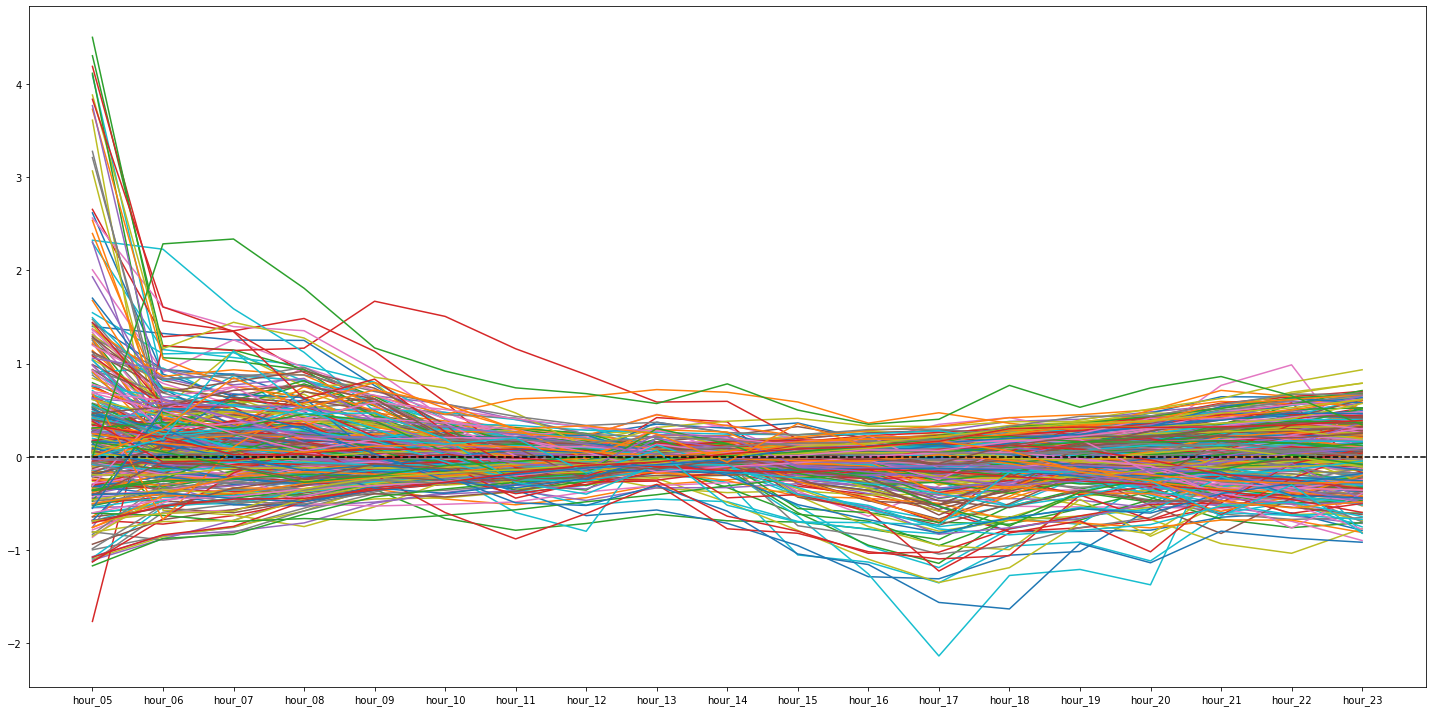

In [14]:
fig, ax = plt.subplots(figsize=(20,10))

for st in all_stations:
    temp = IO[IO["name"]==st]
    ax.plot(temp["time"], temp["logIO"])
    
ax.axhline(y=0, ls="--", c='k')
plt.tight_layout()

In [15]:
bins = [ i*0.2-3 for i in range(40) ]

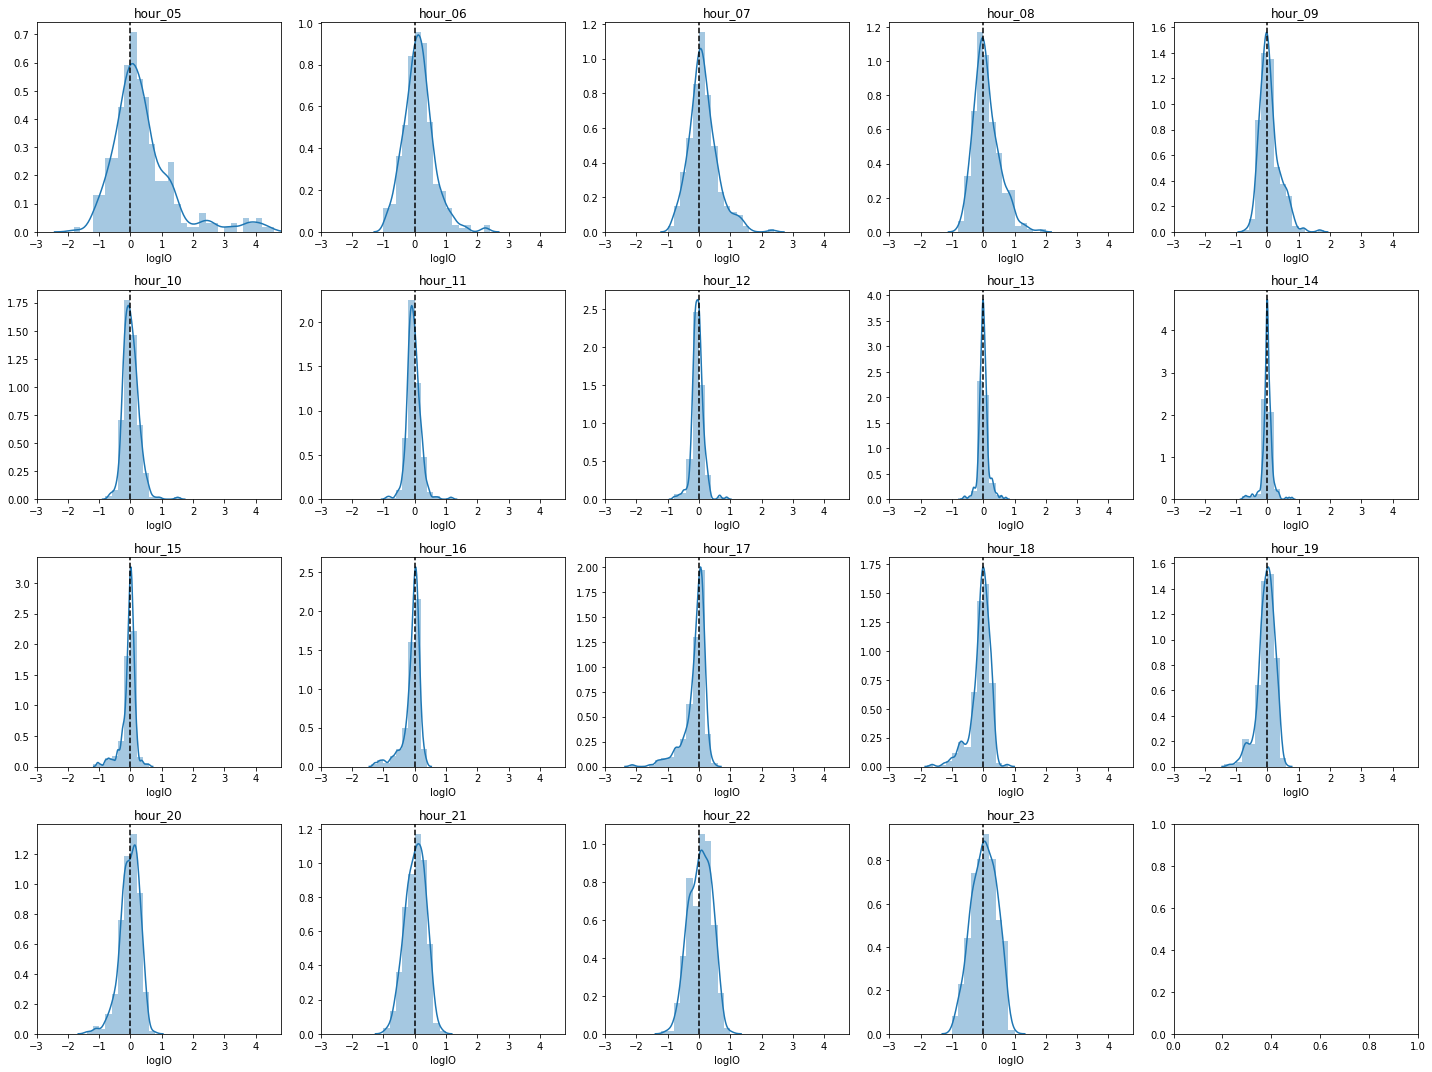

In [16]:
fig, axg = plt.subplots(4,5, figsize=(20,15))
axs = axg.flatten()
i = 0
for hr in range(5,24):
    ax = axs[i]
    hr_str = "hour_{}".format(str(hr).zfill(2))
    temp = IO[IO["time"]==hr_str]
    sns.distplot(temp["logIO"], ax=ax, kde=True, bins=bins)
    ax.set_title(hr_str)
    ax.set_xlim([min(bins), max(bins)])
    ax.axvline(x=0, c="k", ls="--")
    i+=1
    #break
plt.tight_layout()

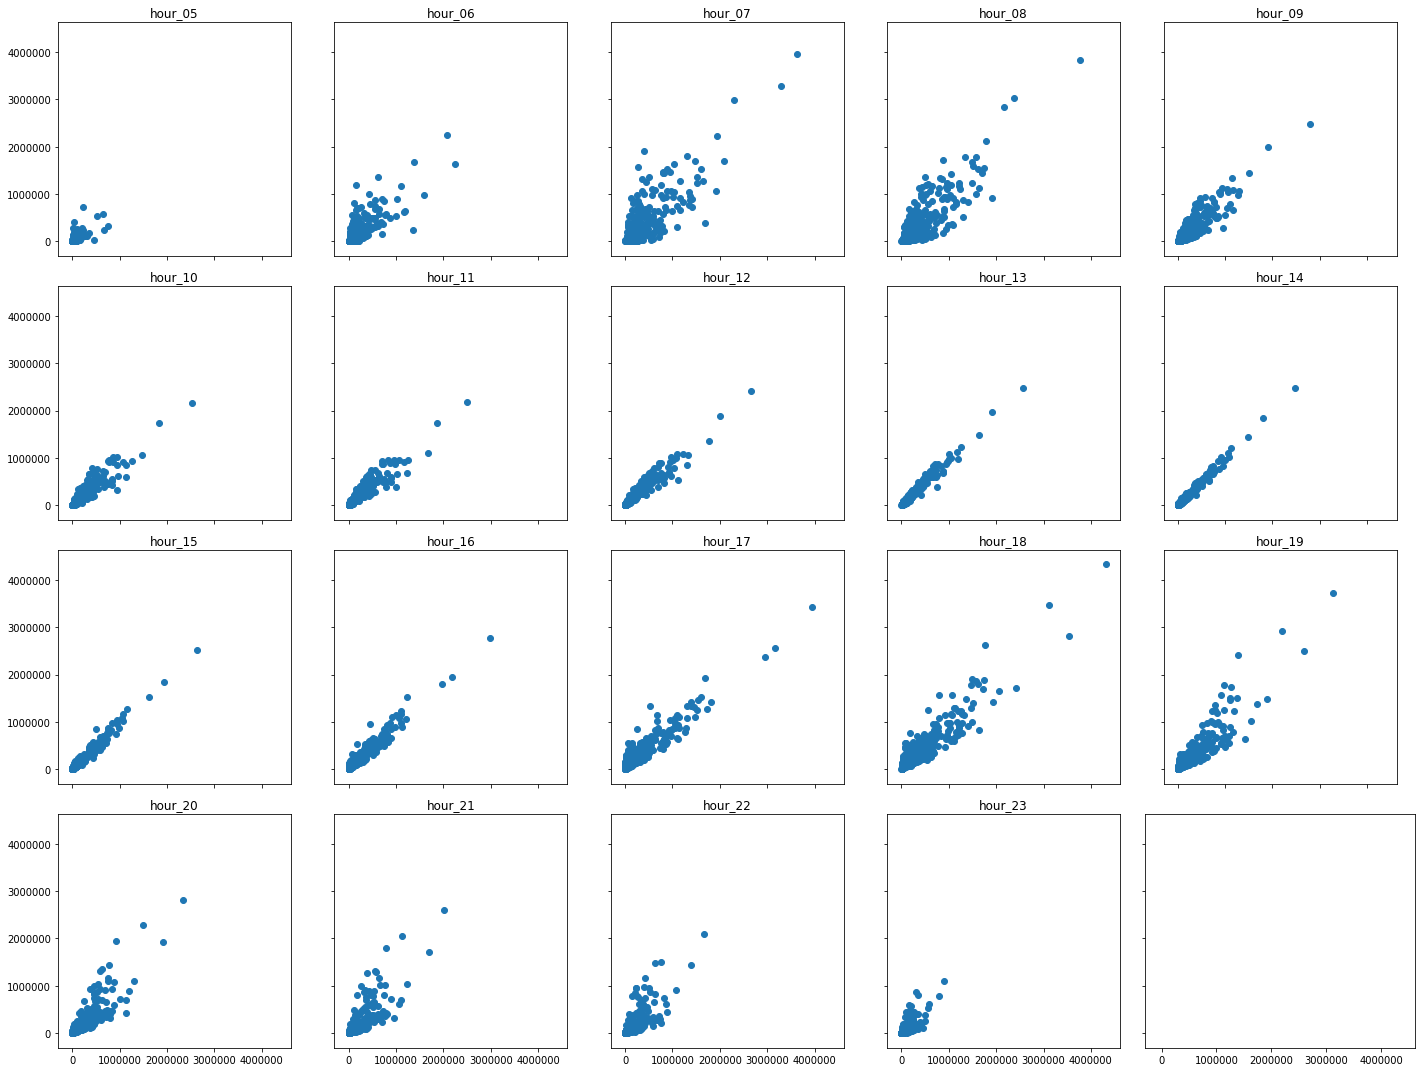

In [21]:
fig, axg = plt.subplots(4,5, figsize=(20,15), sharex=True, sharey=True)
axs = axg.flatten()
i = 0
for hr in range(5,24):
    ax = axs[i]
    hr_str = "hour_{}".format(str(hr).zfill(2))
    temp = IO[IO["time"]==hr_str]
    #sns.distplot(temp["logIO"], ax=ax, kde=True, bins=bins)
    ax.scatter(temp["in"], temp["out"])
    ax.set_title(hr_str)
    #ax.set_xlim([min(bins), max(bins)])
    #ax.axvline(x=0, c="k", ls="--")
    #ax.plot([0, ])
    ax.set_aspect("equal")
    i+=1
    #break
plt.tight_layout()

In [43]:
all_stations2 = list( set(df2["origin"]) | set(df2["destination"]) )
len(all_stations2)

306

In [44]:
IO2 = None

for st in tqdm(all_stations2):
    temp_out = df2[df2["origin"]==st] # outgoing
    temp_out = temp_out[[ col for col in temp_out.columns if col not in ["origin", "destination"] ]].sum()
    temp_out = pd.DataFrame({"out": temp_out})
    temp_in = df2[df2["destination"]==st]#.sum() # incoming
    temp_in = temp_in[[ col for col in temp_in.columns if col not in ["origin", "destination"] ]].sum()
    temp_in = pd.DataFrame({"in": temp_in})
    temp = pd.merge(temp_in, temp_out, left_index=True, right_index=True)
    temp["IO"] = (temp["in"]+1) / (temp["out"]+1)
    temp["logIO"] = np.log10(temp["IO"])
    temp["name"] = st
    temp = temp.reset_index(drop=False).rename(columns={"index": "time"})
    #print(temp)
    #plt.plot(temp["logIO"])
    if IO2 is None:
        IO2 = temp
    else:
        IO2 = IO2.append(temp)
    #break

100%|██████████| 306/306 [00:03<00:00, 81.21it/s]


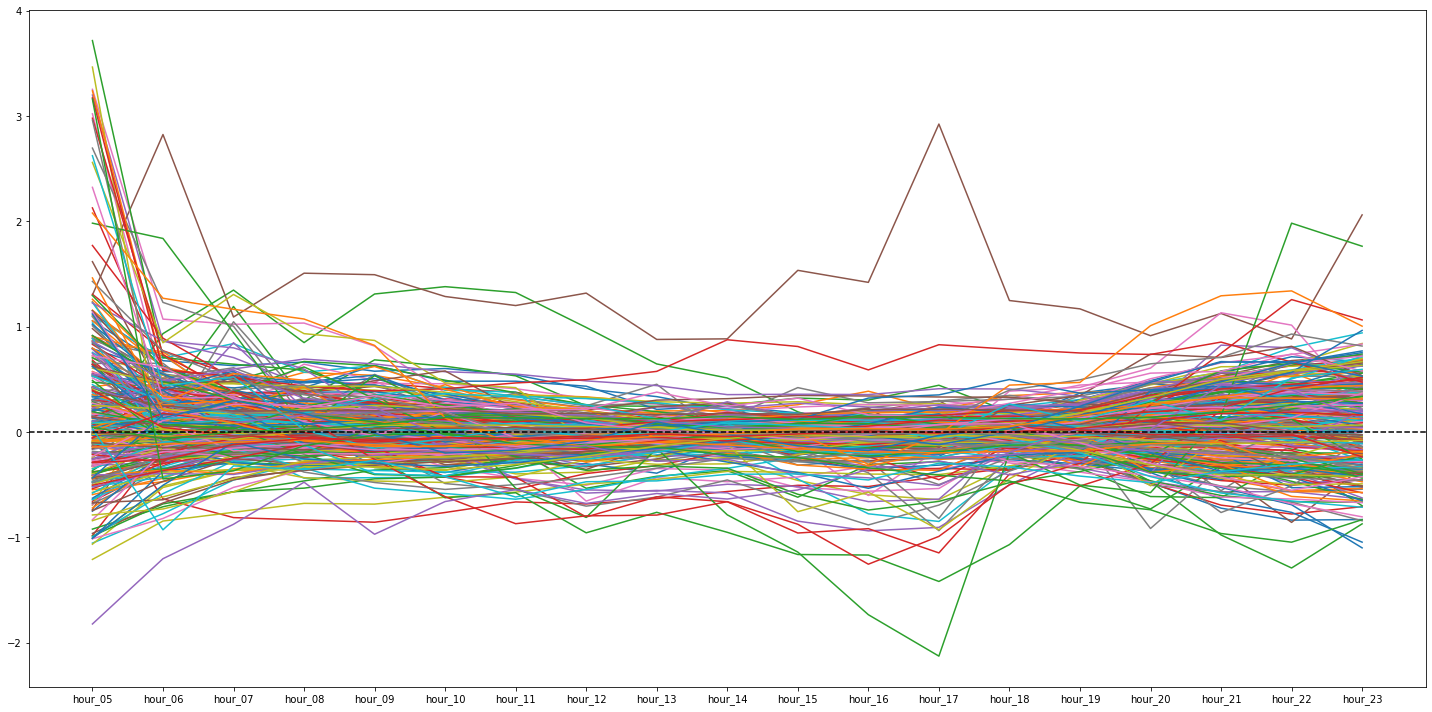

In [45]:
fig, ax = plt.subplots(figsize=(20,10))

for st in all_stations:
    temp = IO2[IO2["name"]==st]
    ax.plot(temp["time"], temp["logIO"])
    
ax.axhline(y=0, ls="--", c='k')
plt.tight_layout()

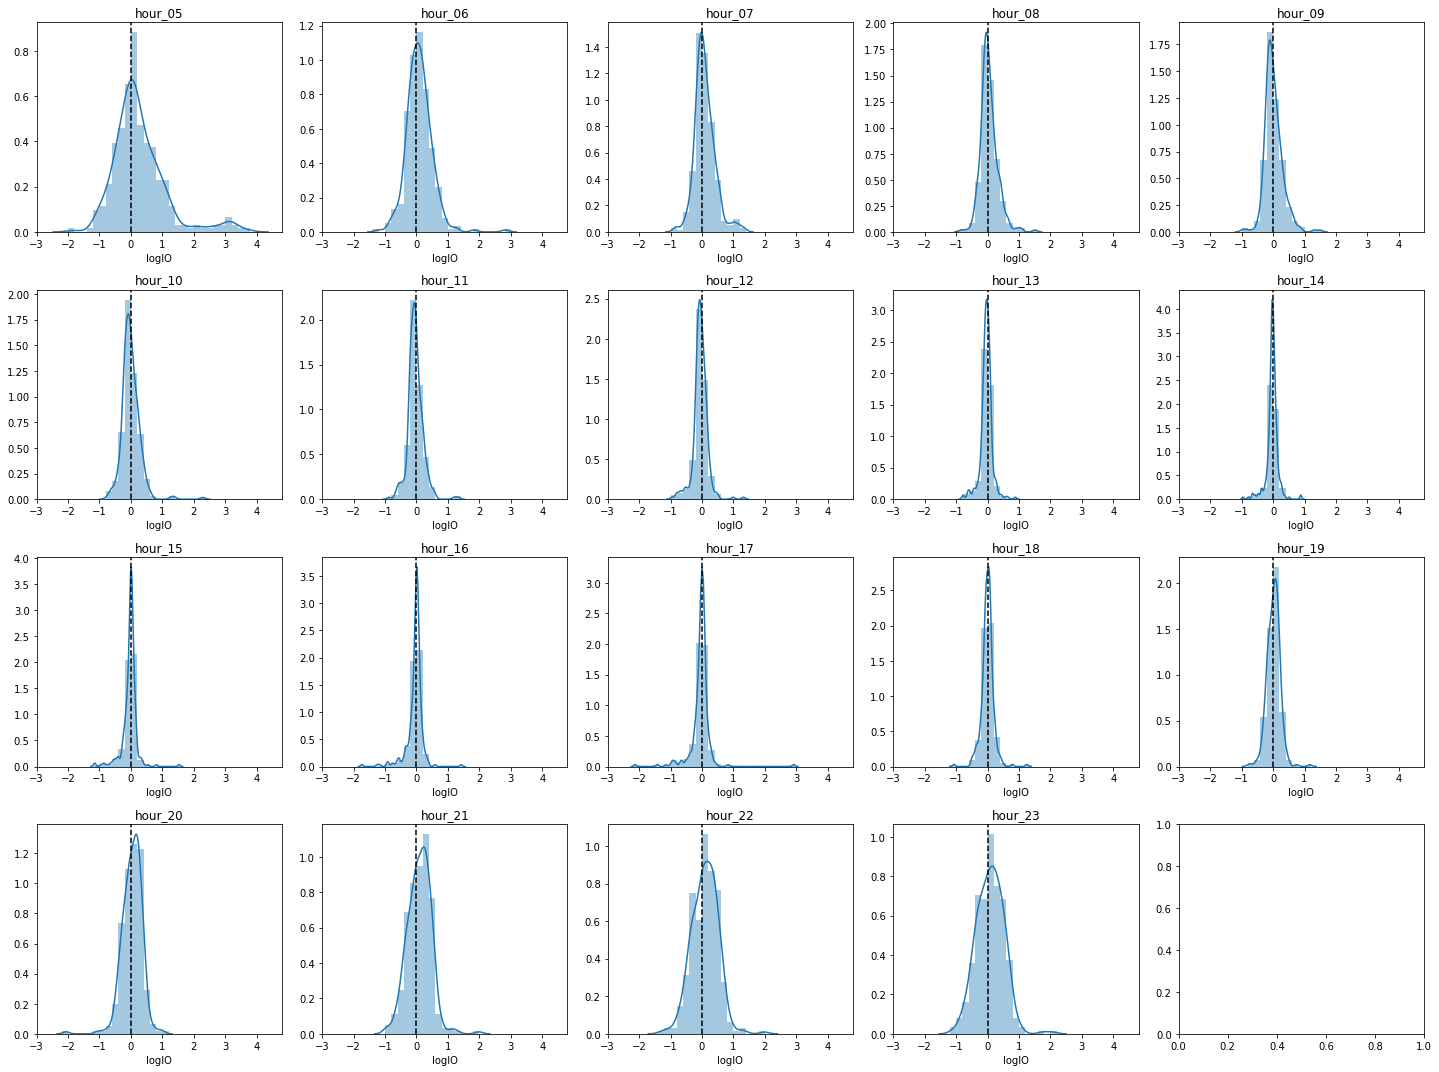

In [68]:
fig, axg = plt.subplots(4,5, figsize=(20,15))
axs = axg.flatten()
i = 0
for hr in range(5,24):
    ax = axs[i]
    hr_str = "hour_{}".format(str(hr).zfill(2))
    temp = IO2[IO2["time"]==hr_str]
    sns.distplot(temp["logIO"], ax=ax, kde=True, bins=bins)
    ax.set_title(hr_str)
    ax.set_xlim([min(bins), max(bins)])
    ax.axvline(x=0, c="k", ls="--")
    i+=1
    #break
plt.tight_layout()